In [235]:
import numpy as np
import math
from scipy.stats import chisquare
import matplotlib.pyplot as plt
from scipy.stats import poisson

## Task 1: Erlang system

In [236]:
def unnormalized_truncated_poisson(i, mean_arrival = 1, mean_service = 8):
    A = mean_arrival * mean_service
    return A**i/math.factorial(i)

def MetropolisHastings(initial_state, num_samples, max_state, mean_arrival=1, mean_service=8):
    samples = []
    curr_state = initial_state

    # propose a move: 
    for i in range(num_samples):
        proposal = int(np.random.uniform(0, max_state + 1))
        if proposal < 0 or proposal > max_state:
            proposal = curr_state
        
        p_curr = unnormalized_truncated_poisson(curr_state, mean_arrival, mean_service)
        p_prop = unnormalized_truncated_poisson(proposal, mean_arrival, mean_service)

        acceptance_ratio = min(1, p_prop/p_curr)

        # accept or reject
        if np.random.uniform(0,1) < acceptance_ratio: 
            curr_state = proposal

        samples.append(curr_state)

    return samples

In [237]:
samples = MetropolisHastings(0, 1000000, 10)
samples = samples[300000:] # discard warm-up samples

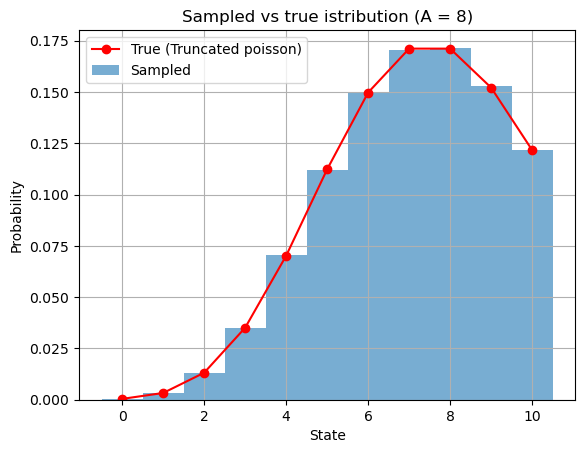

In [238]:
def plot_histogram(samples, A, max_state):
    plt.hist(samples, bins=np.arange(max_state + 2) - 0.5, density=True, alpha=0.6, label="Sampled")

    # overlay the true Poisson PMF (truncated and normalized)
    x = np.arange(0, max_state + 1)
    true_probs = poisson.pmf(x, mu=A)
    true_probs /= true_probs.sum()  # normalize over truncated range

    plt.plot(x, true_probs, 'o-', color='red', label='True (Truncated poisson)')
    plt.xlabel("State")
    plt.ylabel("Probability")
    plt.title(f"Sampled vs true istribution (A = {A})")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histogram(samples, A=8, max_state=10)


Verify with $\chi^2$ test

In [239]:
def chi2_test(samples, mean_arrival=1, mean_service=8, max_state=10):
    counts = np.bincount(samples, minlength=max_state+1)
    expected_unnorm = np.array([unnormalized_truncated_poisson(i, mean_arrival, mean_service) for i in range(max_state+1)])
    expected_probs = expected_unnorm / expected_unnorm.sum()
    expected_counts = expected_probs * len(samples)

    # merge bins from the tail while expected counts < 5
    while expected_counts[-1] < 5 and len(expected_counts) > 1:
        expected_counts[-2] += expected_counts[-1]
        counts[-2] += counts[-1]
        expected_counts = expected_counts[:-1]
        counts = counts[:-1]   

    # merge bins from the front while expected counts < 5
    while expected_counts[0] < 5 and len(expected_counts) > 1:
        expected_counts[1] += expected_counts[0]
        counts[1] += counts[0]
        expected_counts = expected_counts[1:]
        counts = counts[1:]

    #expected_counts = np.array([int(i) for i in expected_counts])

    stat, p = chisquare(f_obs=counts, f_exp=expected_counts)
    return stat, p

In [240]:
stat, p = chi2_test(samples, 1, 8, max_state=10)
print(f"Chi-squared stat: {stat:.2f}, p-value: {p:.4f}")

Chi-squared stat: 8.59, p-value: 0.5712


## Task 2: Two call types

## 